## Aggregate Metrics into Figures of Merit ##

**Credit:** Fabio Ragosta (INAF) with input from Xiaolong Li (UDel), 2020-08-03. 

Very minor edits by Will Clarkson, UM-Dearborn

**The notebook presents a function which take as input the bundleDicts from the metric and it builds a bar plot with the rank of all the opsims. The rank is estimated summing the metric value all over the footprint.**

In [97]:
# Your username (for locating the MAF output to be plotted)
your_username = 'wiclarks'

# directory in your persistent workspace with MAF output
searchTail = 'MAFOutput/MetricData/PM' 

# Path for output table
pathTableOut = './testFoMs.csv'

In [98]:
%matplotlib inline
import sys,os, glob
import numpy as np
import math
from lsst.sims.maf.utils.opsimUtils import *
from opsimUtils import *
import matplotlib.pyplot as plt
import pandas as pd
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
from builtins import zip

In [99]:
# to aggregate the results into a table for convenient output
from astropy.table import Table, Column

In [100]:
## plt.style.use('seaborn') # moved to lower down in the notebook to take effect
plt.rc('legend', fontsize=10)

- your_username has to be set to be able to access to the proper directory.

- outDir has to be set to be able to access to the MAFOutput file.

In [101]:
## your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')
    
# outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/PM'.format(your_username)
outDir = '/home/idies/workspace/Storage/{}/persistent/{}'.format(your_username, searchTail)


resultDbs = getResultsDbs(outDir)

# the following line will be useful if you did not run MAF on all 75 opsims
#Here we upload the results from the MAFoutput of interest
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in runNames:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, outDir)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

nomalization factors and/or tresholds for the FOM and MAF values can be set in the function to plot the selection we want to show.

- norm can be a string ('std'),in this case it apply as normalization the standard deviation of the MAF distribution over the footprint; norm can be None, in this case no normalization is applyed; norm can be a dictionary with the normalization value for all the opsim for the number of metrics we want to plot.

- threshold_max is the upper limit for the threshold.

- treshold_max is the lower limit for the threshold.

- byfamily is a boolean variable, if True the Opsims are sorted by theri families.

In [104]:
def get_family(df):
    """get family of opsim"""    
    return df[0].split('_')[0]

def FOM(bundleDicts, norm=None, treshold_min =None, treshold_max =None, filename=None, byfamily=True, \
        tablePath='', Verbose=True, **karg):
    data_bundle = {}
    data = {}
    FOMs = []
    runNames= list(bundleDicts.keys())
    metrics = bundleDicts[runNames[0]].keys()
          
    for metric in metrics:
        data_bundle[metric]={}
        data[metric]={}
        FOM=[]
        for runName in runNames: 
            data_bundle[metric][runName]= pd.DataFrame(bundleDicts[runName][metric].metricValues[np.where(bundleDicts[runName][metric].metricValues.mask == False)])[0]
            data[metric][runName]= [] 
            for i in range(len(data_bundle[metric][runName])):        
                if data_bundle[metric][runName][i]:
                    data[metric][runName].append(data_bundle[metric][runName][i])
            data[metric][runName]=np.array(data[metric][runName])[np.where(np.isfinite(data[metric][runName]))]
            if treshold_min !=None and treshold_max !=None :
                ID_fom=np.where((data[metric][runName]>treshold_min) & (data[metric][runName]<treshold_max))
            else:
                if treshold_min !=None:
                    ID_fom=np.where(data[metric][runName]>treshold_min)
                elif treshold_max !=None :
                    ID_fom=np.where(data[metric][runName]<treshold_max)
                else:
                    ID_fom=np.repeat(True, len(data[metric][runName]))
            if norm =='std':
                # (WIC I think this max() may have been a bug. Replaced with np.std(().)
                N= 1.0/np.std(data[metric][runName][ID_fom])
            elif norm==None:
                N=np.repeat(1,len(data[metric][runName][ID_fom]))
            else:
                N=norm[metric][runName][ID_fom]
            fom = np.array(data[metric][runName][ID_fom])*N
            FOM.append(fom.sum())
        FOM=np.array(FOM)
        FOMs.append(FOM) 
    
    # 2020-08-05 package the FOMs into a table so that we can output to disk
    if len(tablePath) > 3:
        tWrite = Table()
        tWrite['runNames'] = runNames
        for iMetric in range(len(metrics)):
            thisFom = FOMs[iMetric]
            colName = list(metrics)[iMetric][-1] # keys are a dict_keys object
            thisCol = Column(name=colName, data=thisFom)
            tWrite.add_column(thisCol)
        tWrite.add_column(Column(name='FomSum', data=np.sum(FOMs, axis=0)))
            
        tWrite.write(tablePath, overwrite=True)
        if Verbose:
            print("Written FoM sums to path %s. Contents:" % (tablePath))
            # syntax to make the output look nice in the terminal, without
            # changing the original table values
            tShow = Table(data=tWrite[0:3], copy=True)
            for colSho in tShow.colnames:
                if colSho == 'runNames':
                    continue
                tShow[colSho].format='%.3f'
            tShow.pprint()
            
    # --- end of syntax to construct and write table --- 
            
    import matplotlib.cm as cm
    plt.rcdefaults()
    
    # Apply the style sheet here.
    plt.style.use('seaborn-dark')
     
    fig, ax = plt.subplots(figsize=(8,30))
    y_pos = np.arange(len(bundleDicts.keys()))
    colorlist = cm.viridis(np.linspace(0, 1, len(FOMs)))
    d= np.zeros(len(runNames))
    dplt=[]
    FOM_labels= list(bundleDicts[runNames[0]].keys())
    df_new = pd.DataFrame(bundleDicts.keys(), columns=['db'])
    for i, (FOM, maf) in enumerate(zip(FOMs,FOM_labels)):
        d = d+ FOM
        #dplt.append(d)
        df_new[maf]= d
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.4_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.4_10yrs", "") )
    df_new['family'] = df_new.apply(get_family, axis=1)

    # 2020-08-05 dropped in Fabio's new "byFamily" option
    if byfamily:
        df_ = df_new.sort_values(by=[ 'family',FOM_labels[-1]], ascending=[False, False])
    else:
        df_ = df_new.sort_values(by=[FOM_labels[-1]], ascending=[False])
    
    ##df_ = df_new.sort_values(by=[ 'family',FOM_labels[-1]], ascending=[False, False])
    #idx = sorted([name_tick,d], key = lambda x: (x[1],x[2]))
    #idx=np.argsort((d,name_tick))
    #idx=idx[::-1]
    
    for i in reversed(range(len(FOMs))):
        #ax.barh(y_pos,dplt[i][idx], align='center',color=colorlist[i],label=FOM_labels[i], **karg)
        ax.barh(df_['db'],df_[FOM_labels[i]], align='center',color=colorlist[i],label=FOM_labels[i], \
                zorder=5, **karg)
    
    # 2020-08-05 dropped in fabio's new byfamily option
    xmin, xmax= ax.get_xlim()
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()[FOM_labels[-1]].values - 0.5
        hlines = [hlines, hlines]   
    ax.plot((xmin, xmax), hlines, 'k-', linewidth=1, alpha=0.5)
    ax.set_yticks(y_pos)
    #ax.set_yticklabels(name_tick, size=20)
    ax.set_yticklabels(df_['db'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('FoM', fontsize=20)
    leg = ax.legend(loc='upper right', fontsize=14, frameon=True)
    legFrame = leg.get_frame()
    legFrame.set_color('white')
    
    # Add vertical gridlines
    ax.grid(which='both', axis='x', color='w', alpha=0.9, zorder=1, lw=1)
    
    if filename!=None:
        plt.savefig(filename+'.png')
    plt.close()
    return fig

Written FoM sums to path ./testFoMs.csv. Contents:
        runNames         LSPMmetric TransienPM confusionmetric  FomSum 
------------------------ ---------- ---------- --------------- --------
      spiders_v1.4_10yrs    121.370    765.479         743.514 1630.364
       agnddf_v1.4_10yrs    147.211    777.393         500.710 1425.313
twi_filters_5_v1.4_10yrs    136.950    770.357         743.557 1650.864


UnboundLocalError: local variable 'hlines' referenced before assignment

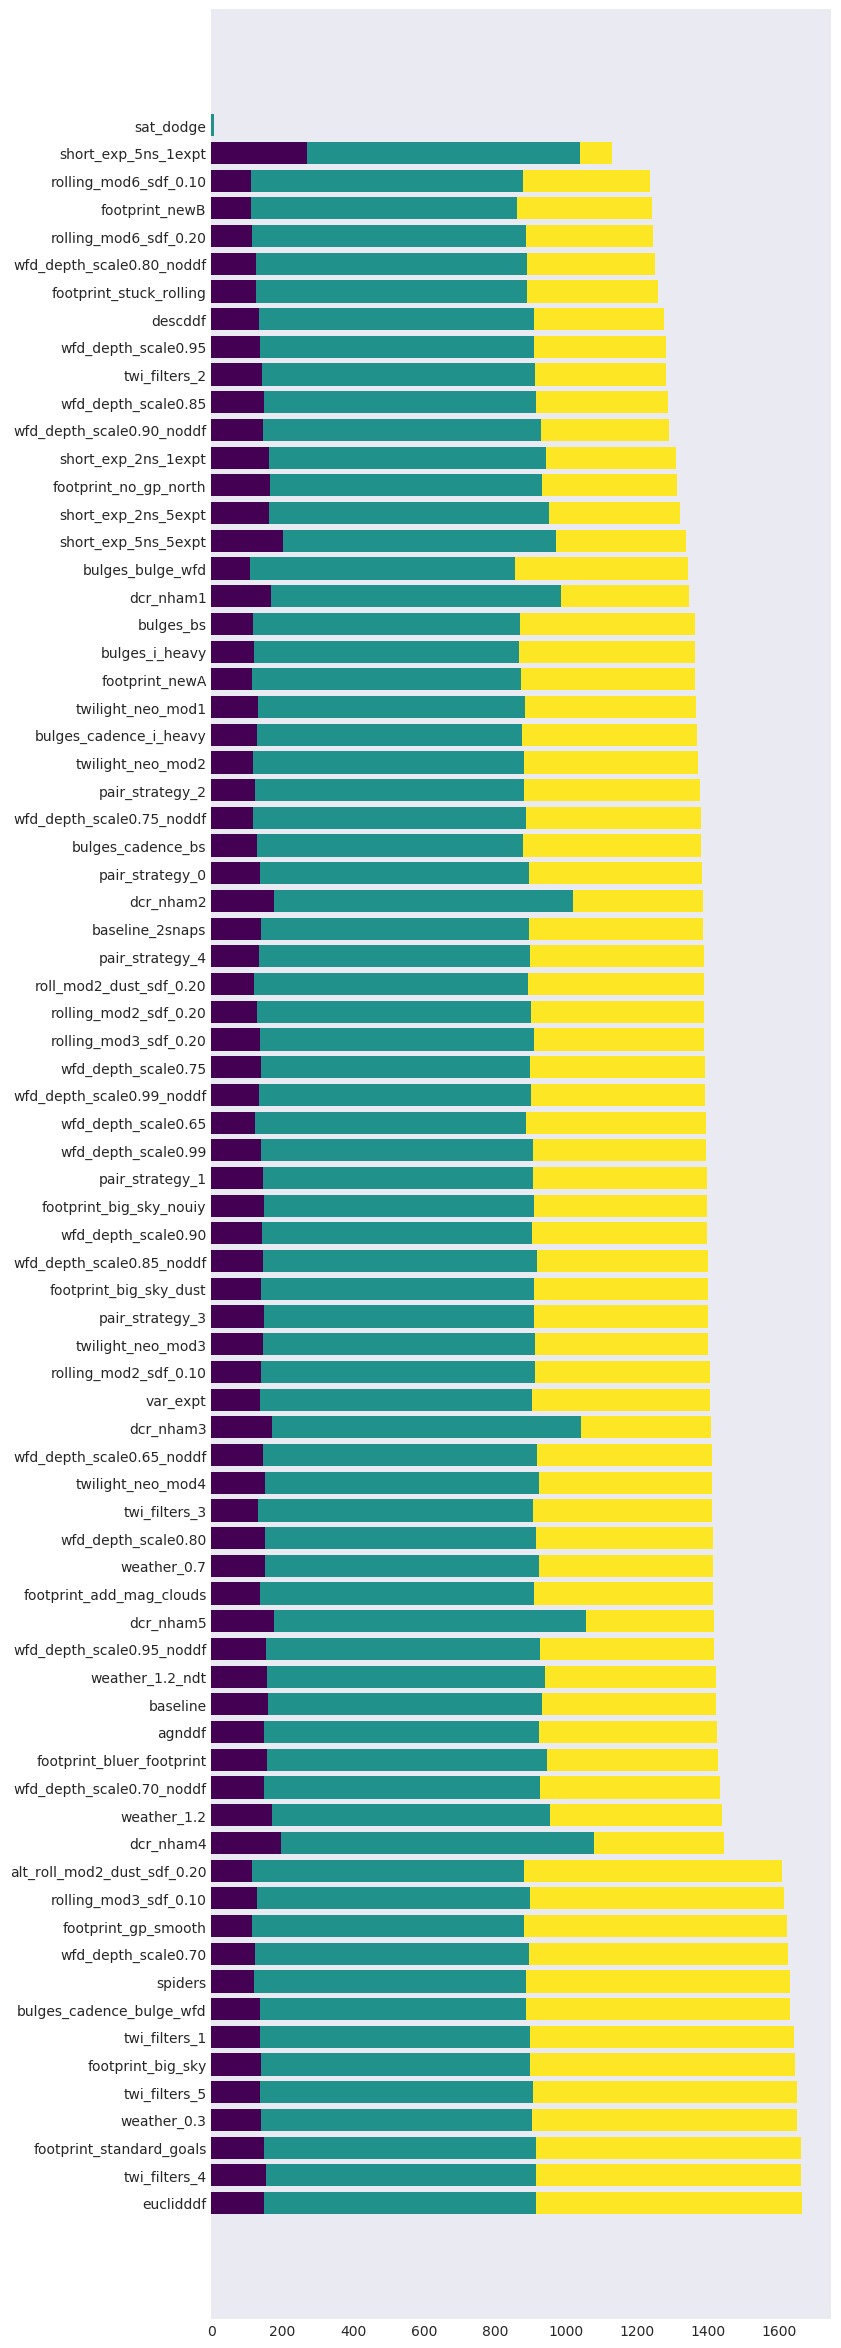

In [105]:
# example call including writing the table of the FoMs to disk and 
# showing the first few lines of the table to terminal. 
FOM(bundleDicts, tablePath=pathTableOut, Verbose=True, byfamily=False)